# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [49]:
print ("The dataset collected is related to 17 campaigns")

The dataset collected is related to 17 campaigns


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time



In [51]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [52]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [53]:
df = df.replace("unknown", np.nan)  # Replace 'unknown' with NaN
df = df.dropna()  # Drop rows with NaN values in any column

In [54]:
# getting rid of duration as to have a more realistic predictive model
df = df.drop(columns=['duration', 'pdays'])

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Key Goals:

Identify Factors Influencing Customer Response: 
    Understand which features contribute most significantly to a customer's likelihood of subscribing to a term deposit.

Model Performance Comparison: 
    Compare the accuracy, precision, recall, and other relevant metrics of the classifiers to determine the most effective model for this task.
    
Optimization of Marketing Strategies: 
    Provide actionable insights that can help the bank tailor its marketing strategies to focus on high-potential customer segments.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [56]:
X = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'campaign', 'previous', 'poutcome']]
y = df['y'] 

# Convert the target column to binary
y = y.map({'yes': 1, 'no': 0})  

# Defining categorical and numeric features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
numeric_features = ['age', 'campaign', 'previous']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Scale numeric features
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # One-hot encode categorical features
    ]
)


X_encoded = preprocessor.fit_transform(X)




### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [58]:
baseline_accuracy = y.value_counts(normalize=True).max()

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

Baseline Accuracy: 87.34%


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [59]:
log_reg_model = LogisticRegression(random_state=42)

log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [60]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2%}")



Test Accuracy: 88.35%


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [61]:
#Creating models with default settings

# Initialize a list to store model performance results
results = []

# Logistic Regression
start_time = time.time()
log_reg_model.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = log_reg_model.score(X_train, y_train)
test_accuracy = log_reg_model.score(X_test, y_test)
results.append(['Logistic Regression', train_time, train_accuracy, test_accuracy])

# K-Nearest Neighbors
start_time = time.time()
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = knn_model.score(X_train, y_train)
test_accuracy = knn_model.score(X_test, y_test)
results.append(['KNN', train_time, train_accuracy, test_accuracy])

# Decision Tree
start_time = time.time()
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = dt_model.score(X_train, y_train)
test_accuracy = dt_model.score(X_test, y_test)
results.append(['Decision Tree', train_time, train_accuracy, test_accuracy])

# Support Vector Machine
start_time = time.time()
svm_model = SVC()
svm_model.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = svm_model.score(X_train, y_train)
test_accuracy = svm_model.score(X_test, y_test)
results.append(['SVM', train_time, train_accuracy, test_accuracy])

# results
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
print(results_df)


                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression    0.067043        0.886931       0.883459
1                  KNN    0.000000        0.894382       0.872964
2        Decision Tree    0.312436        0.952861       0.829999
3                  SVM   16.234413        0.887634       0.883022


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

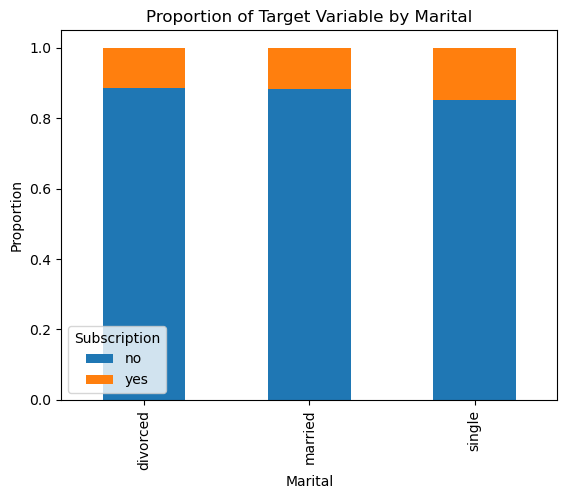

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate proportions for marital status
gender_counts = df.groupby('marital')['y'].value_counts(normalize=True).unstack().fillna(0)

# Plot
gender_counts.plot(kind='bar', stacked=True)
plt.title('Proportion of Target Variable by Marital')
plt.xlabel('Marital')
plt.ylabel('Proportion')
plt.legend(title='Subscription')
plt.show()


The Marital category may be considered for removal as a feature in these models due to the even distribution among the three categories. However, since there are slight differences between them, I have decided to retain this feature.

In [63]:

# KNN Hyperparameter tuning
knn_params = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_grid_search.fit(X_train, y_train)

# Decision Tree Hyperparameter tuning
dt_params = {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5)
dt_grid_search.fit(X_train, y_train)

print(f"KNN Best Params: {knn_grid_search.best_params_}")
print(f"Decision Tree Best Params: {dt_grid_search.best_params_}")


KNN Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
Decision Tree Best Params: {'max_depth': 5, 'min_samples_split': 10}


In [64]:
#running the KNN model with the best params we identified above

start_time = time.time()
knn2_model = KNeighborsClassifier(n_neighbors=9, weights='uniform')
knn2_model.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = knn2_model.score(X_train, y_train)
test_accuracy = knn2_model.score(X_test, y_test)
new_row = pd.DataFrame({
    'Model': ['KNN_tuned'], 
    'Train Time': [train_time], 
    'Train Accuracy': [train_accuracy], 
    'Test Accuracy': [test_accuracy]
})

# Concatenate the new row with the existing DataFrame
results_df = pd.concat([results_df, new_row],ignore_index=True)

In [65]:
#running the decision tree model with the best params we identified above

start_time = time.time()
dt2_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
dt2_model.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = dt2_model.score(X_train, y_train)
test_accuracy = dt2_model.score(X_test, y_test)
new_row = pd.DataFrame({
    'Model': ['Decision_tree_tuned'], 
    'Train Time': [train_time], 
    'Train Accuracy': [train_accuracy], 
    'Test Accuracy': [test_accuracy]
})

# Concatenate the new row with the existing DataFrame
results_df = pd.concat([results_df, new_row],ignore_index=True)

In [66]:
# Define the parameter grid for a hypertunning the Logistic model
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model and accuracy
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)


Best Parameters: {'C': 10}
Best Cross-Validation Accuracy: 0.8868844789587232


In [67]:
# Running the Logistic Regression model with the best params above
start_time = time.time()
log_reg_model2 = LogisticRegression(C=10,max_iter=1000)
log_reg_model2.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = log_reg_model2.score(X_train, y_train)
test_accuracy = log_reg_model2.score(X_test, y_test)
new_row = pd.DataFrame({
    'Model': ['Log_tuned'], 
    'Train Time': [train_time], 
    'Train Accuracy': [train_accuracy], 
    'Test Accuracy': [test_accuracy]
})

# Concatenate the new row with the existing DataFrame
results_df = pd.concat([results_df, new_row],ignore_index=True)

In [68]:
# Define the parameter grid for a SVM model
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Initialize the SVM model
svm_model = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)


Best Parameters: {'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.8866032948681049


In [69]:
# Running the SVM model with the best params above

start_time = time.time()
svm_model2 = SVC(kernel='linear')
svm_model2.fit(X_train, y_train)
train_time = time.time() - start_time
train_accuracy = svm_model2.score(X_train, y_train)
test_accuracy = svm_model2.score(X_test, y_test)
new_row = pd.DataFrame({
    'Model': ['SVC_tuned'], 
    'Train Time': [train_time], 
    'Train Accuracy': [train_accuracy], 
    'Test Accuracy': [test_accuracy]
})

# Concatenate the new row with the existing DataFrame
results_df = pd.concat([results_df, new_row],ignore_index=True)

In [70]:
print (results_df)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression    0.067043        0.886931       0.883459
1                  KNN    0.000000        0.894382       0.872964
2        Decision Tree    0.312436        0.952861       0.829999
3                  SVM   16.234413        0.887634       0.883022
4            KNN_tuned    0.001979        0.889743       0.877555
5  Decision_tree_tuned    0.020389        0.888056       0.883240
6            Log_tuned    0.148857        0.887025       0.883568
7            SVC_tuned    3.270361        0.886603       0.882803


##### Questions